## Case Study : 10 BTC pool

I wanted to look a single pool in depth, studying things like repeated users and sudden spikes of usage to chip away at the privacy provided. Currently it has 1169 deposits but only 12 of them are unspent. I noticed that there were huge swings in usage in my [last post](https://tornadotintin.github.io/usageGraphed.html) which might be interesting to analyse. Also 10 BTC is a lot of money so there should be less amateur mistakes and noise here.

In [30]:
import pandas as pd
import qgrid

In [31]:
poolEventsDf =  pd.read_pickle('mainnet-pool-events.pkl')

In [32]:
# tag accounts and styling
known_accounts = {}

def tag_address(val):
    if val in known_accounts:
        return known_accounts[val]
    return val
def address_link(val):
    return '<a target="_blank" href="https://etherscan.io/address/{}">{}</a>'.format(val, tag_address(val))
def tx_link(val):
    return '<a target="_blank" href="https://etherscan.io/tx/{}">{}</a>'.format(val, val)
def style(df_):
    return df_.style.format({'user':address_link,'id':tx_link})

In [15]:
def parseAmount(amt):
    amt= float(amt)
    if (amt>1): return str(int(amt))
    else :return str(amt)  
poolEventsDf['amount'] = poolEventsDf['amount'].apply(parseAmount)

def getrepeatUsers(eventsDf):
    repeatUserArray = []
    for user, df in eventsDf.groupby('user'):
        df['type'] = df['currency'] +'-'+ df['amount'].apply(parseAmount) +'-'+ df['type']
        local = (df.groupby('type').count()[['amount']])
        local['desc'] = local.index.astype(str) + '(' + local['amount'].astype(str) + ')_'
        repeatUserArray.append([user, local['amount'].sum(), local['desc'].sum()])
    allUsers =  pd.DataFrame(repeatUserArray, columns = ['user','count','desc']).sort_values('count',ascending=False).reset_index(drop=True)
    return allUsers
    # return allUsers[allUsers['count']>1]

In [16]:
# getrepeatUsers(poolEventsDf)

In [43]:
wbtc10poolEvents = poolEventsDf[(poolEventsDf.currency == 'wbtc') & (poolEventsDf.amount == '10')]

In [45]:
repeatWbtc10 = getrepeatUsers(wbtc10poolEvents)

We find all the addresses that interacted with this pool mutiple times and list them in a descending order of the count. 'desc' breaks down the types of interactions. It is sad to see many users breaking the most basic guideline, depositing from and withdrawing to the same address 🤦

In [49]:
repeatWbtc10[repeatWbtc10['count']>1].style.format({'user':address_link})

Now we plot the total deposits and withdrawals across time. Each dot is an interaction the increases the total by one. The color denotes how many other interactions that user has made. Shades at the end of the spectrum (reds, yellows, greens) denote unique users

<IPython.core.display.Javascript object>


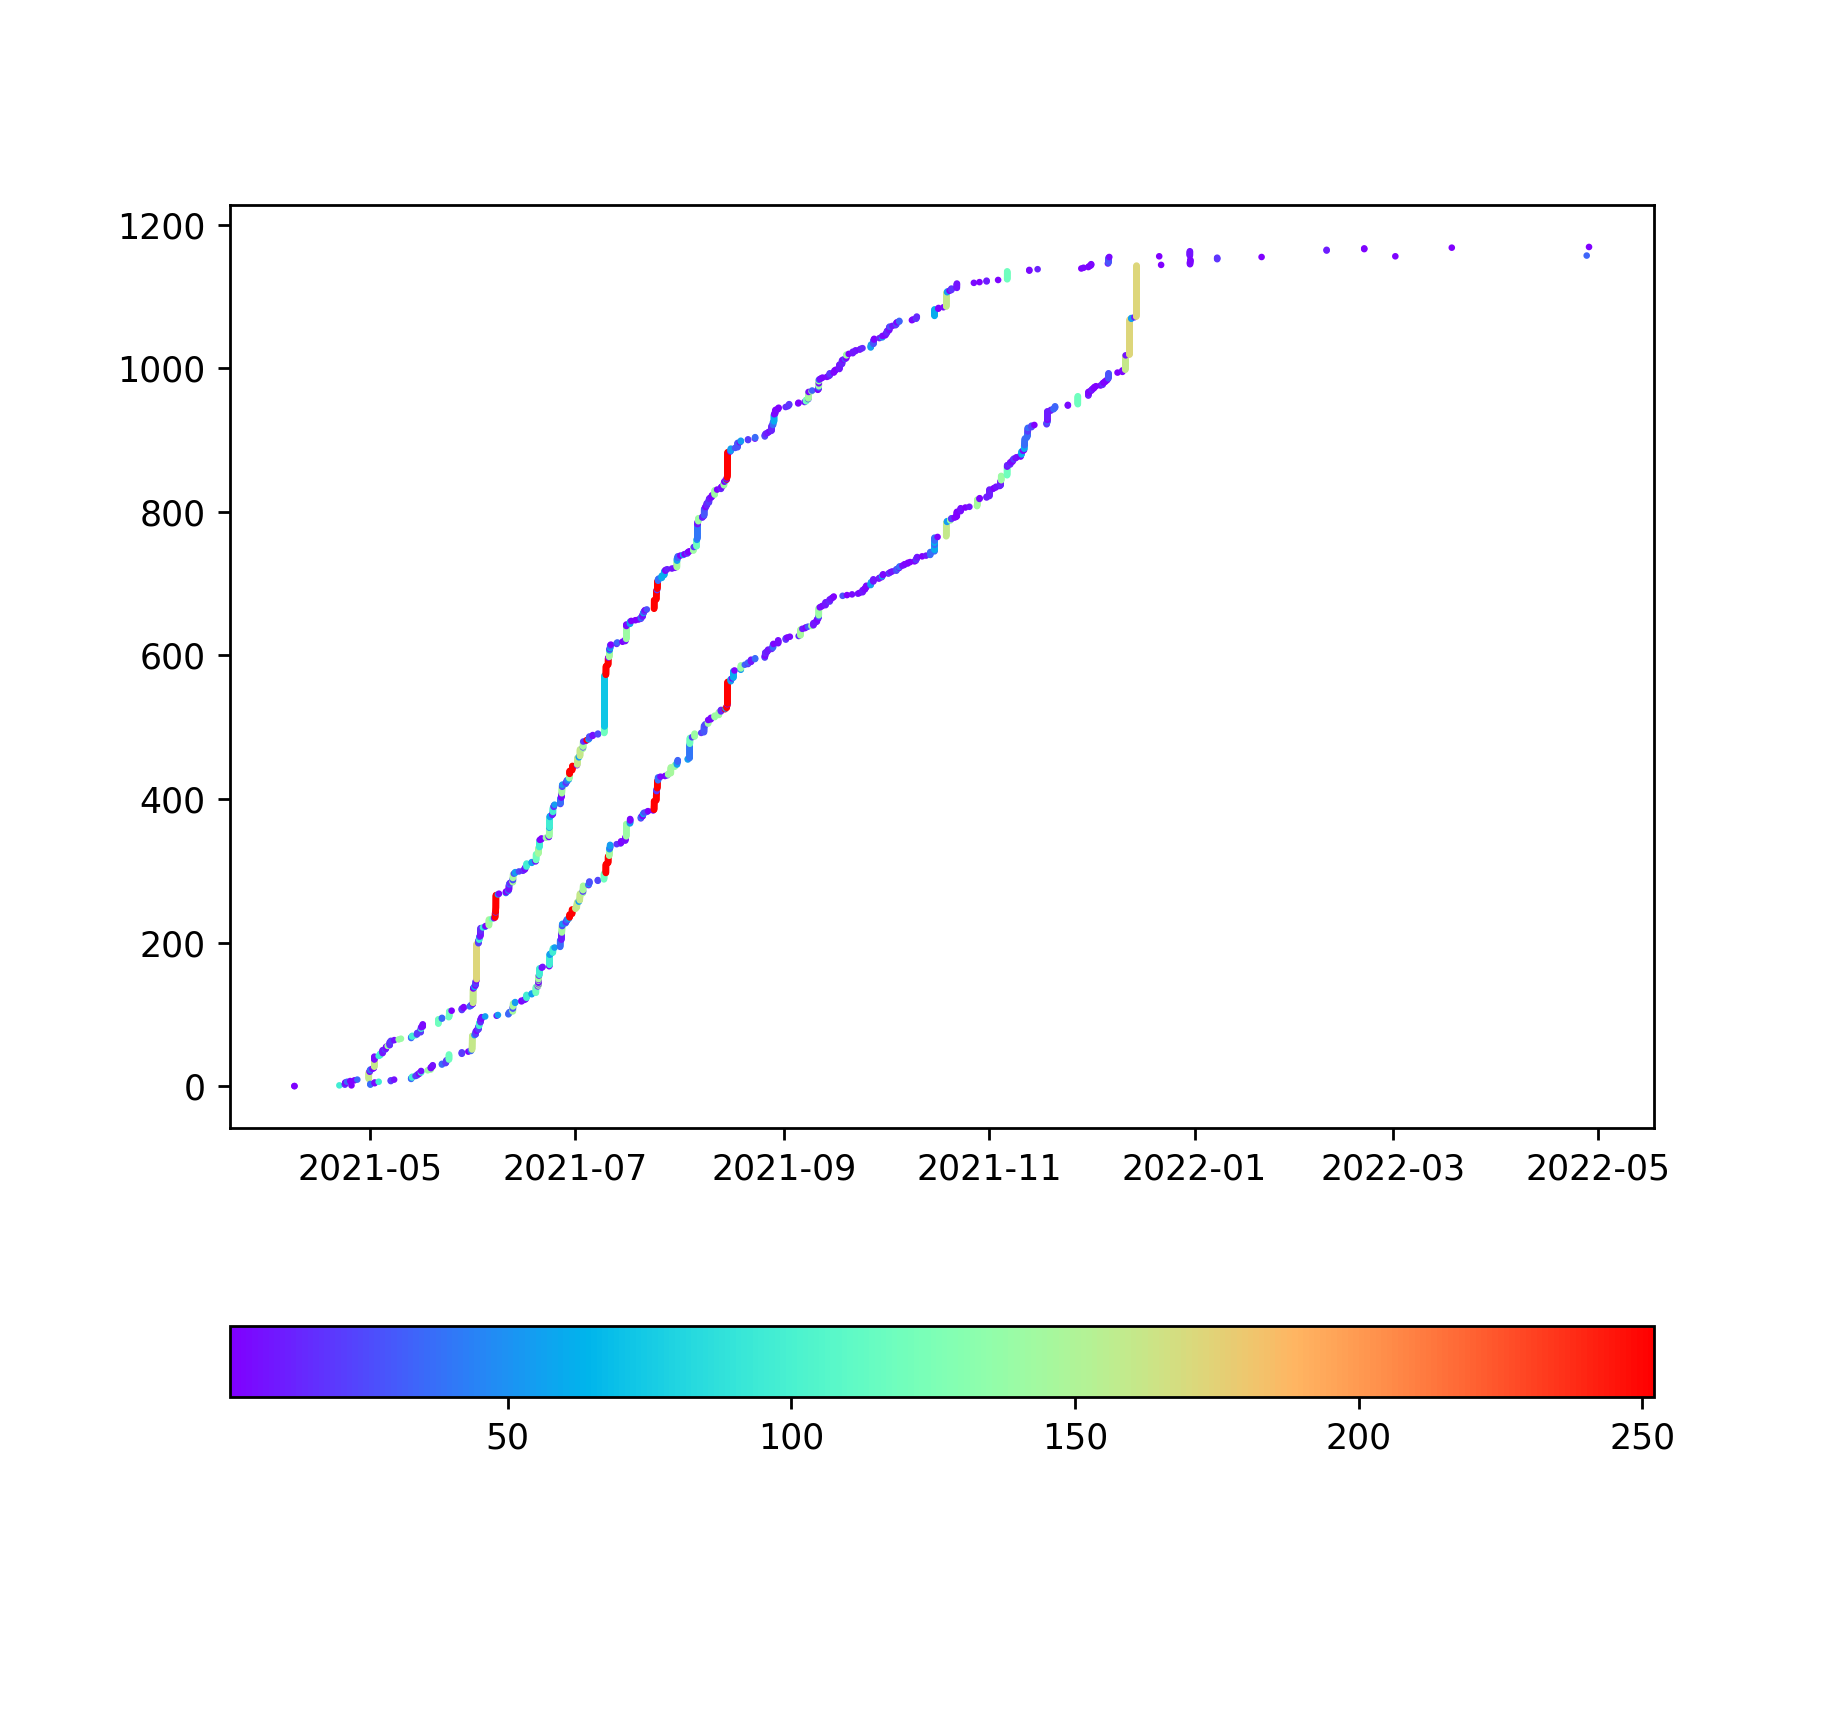

In [21]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

x = wbtc10poolEvents.time
y = wbtc10poolEvents.entry.astype(int)
repeatWbtc10Dict =  repeatWbtc10.set_index('user')
interactions = wbtc10poolEvents.user.apply(lambda x: repeatWbtc10Dict.loc[x])['count']

plt.scatter(x, y, c=interactions, s=0.8, cmap='rainbow')

plt.colorbar(orientation='horizontal')

plt.show()

The same color scheme showing unspent deposits (total deposits - total withdrawals)

<IPython.core.display.Javascript object>


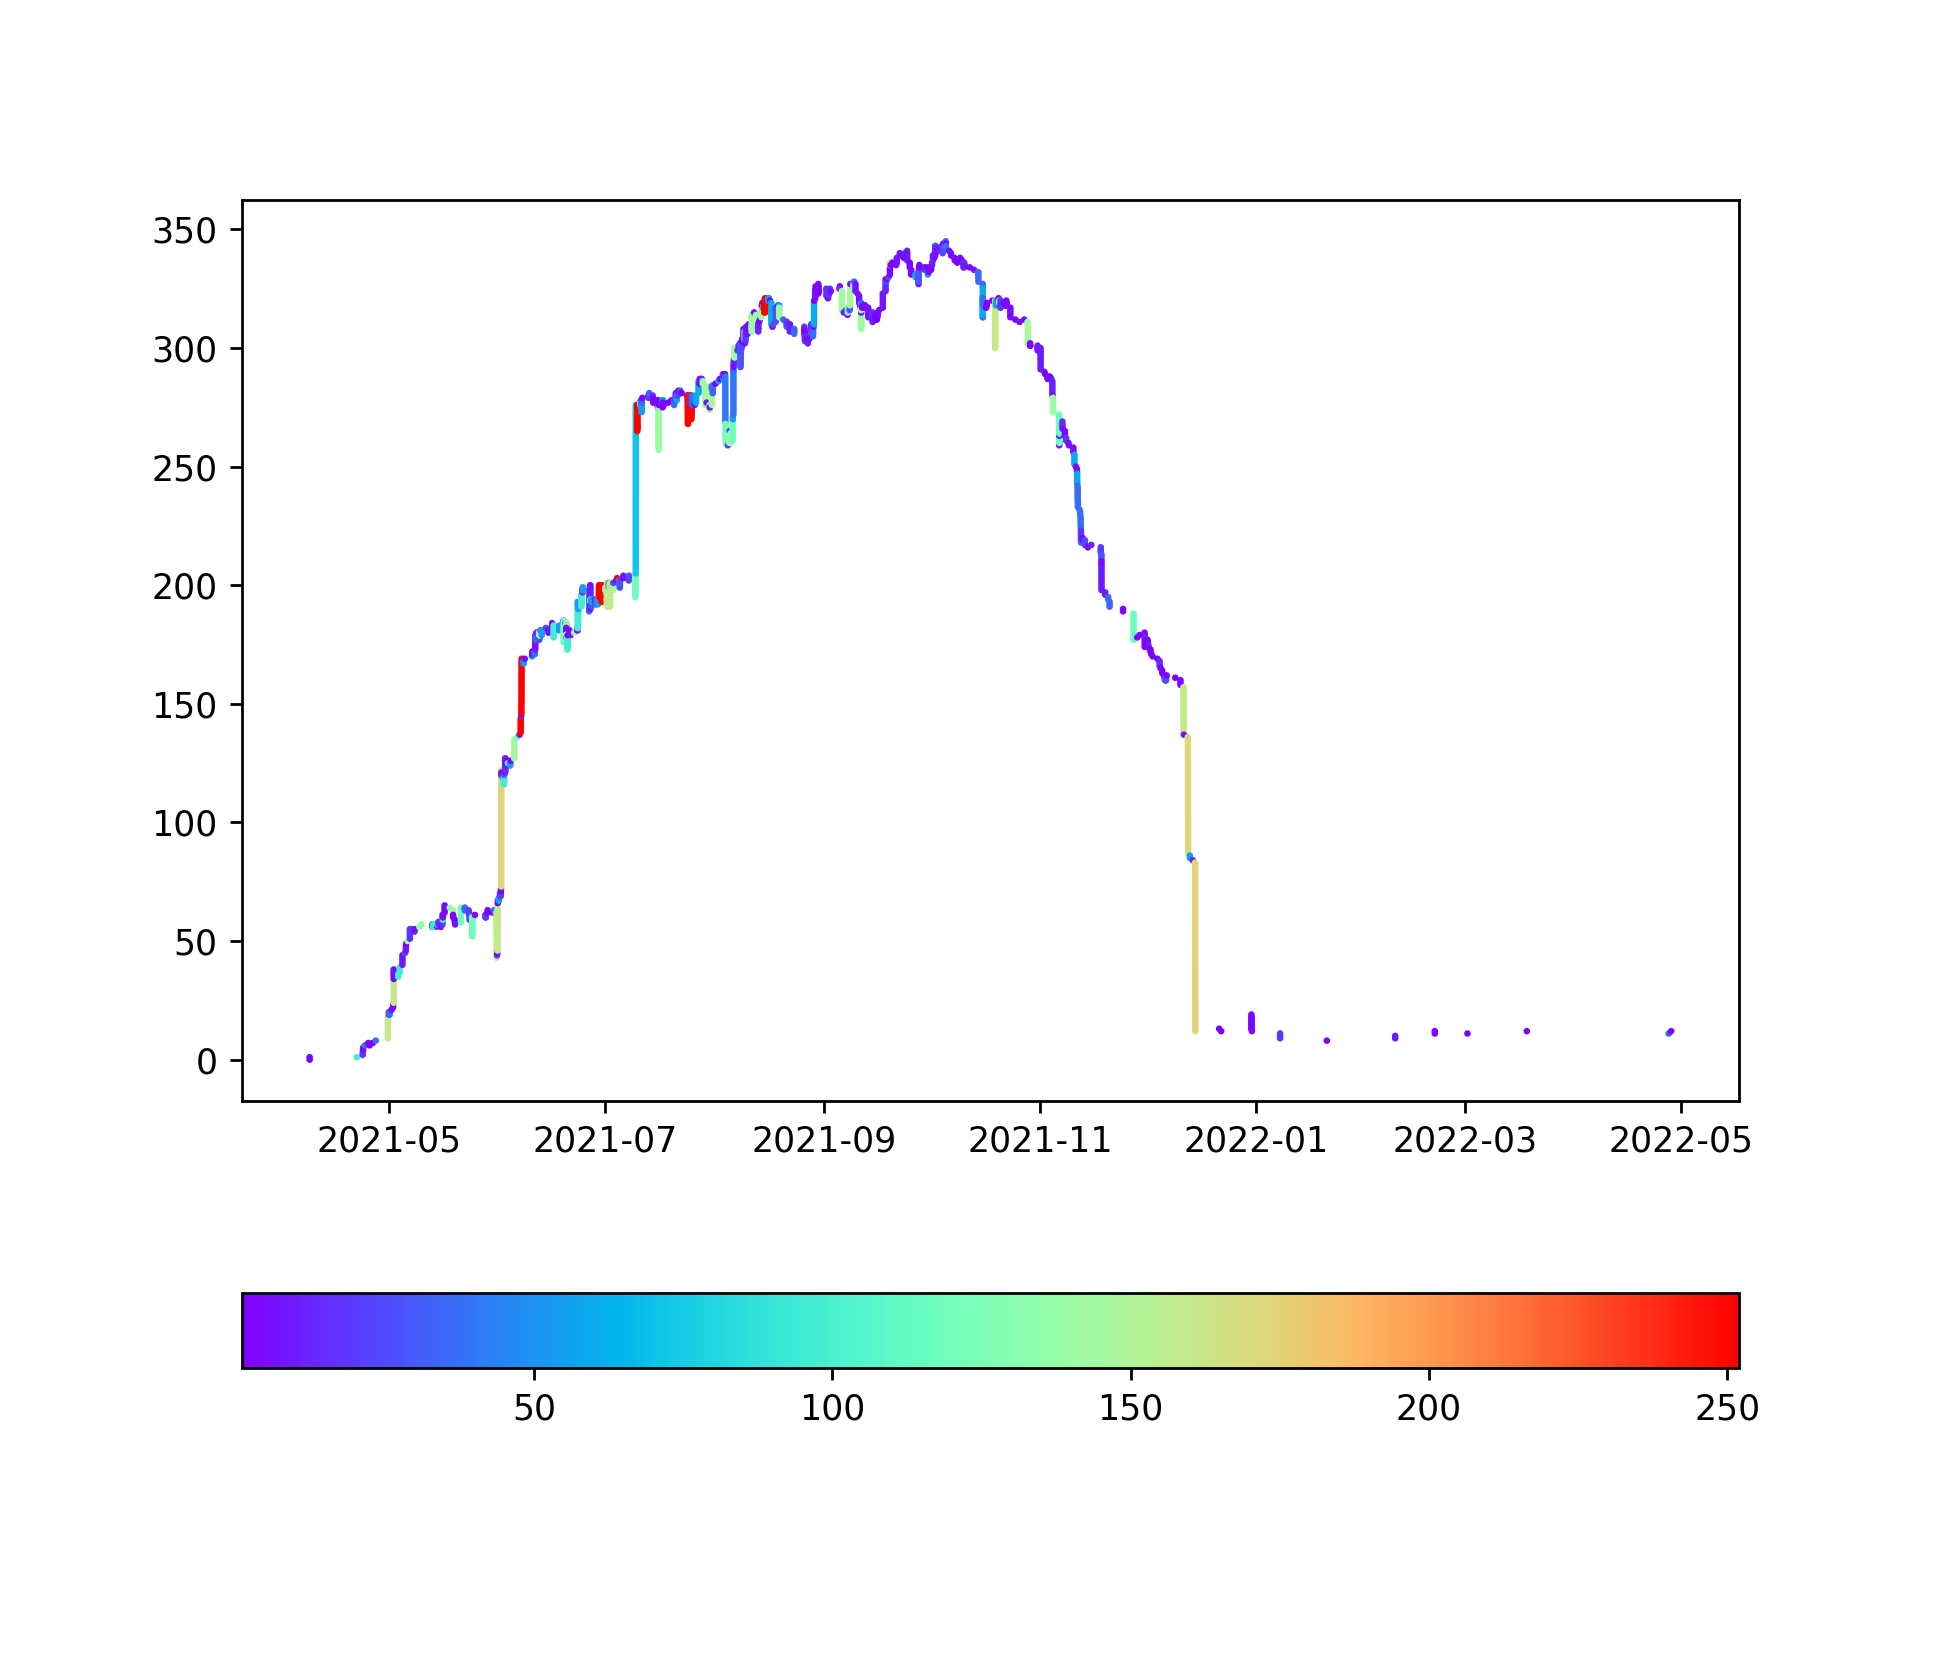

In [22]:
%matplotlib notebook

def offset(typ):
    if (typ == 'D'): return 1
    elif (typ == 'W'): return -1

x = wbtc10poolEvents.time
y = wbtc10poolEvents.type.apply(offset).cumsum()
repeatWbtc10Dict =  repeatWbtc10.set_index('user')
interactions = wbtc10poolEvents.user.apply(lambda x: repeatWbtc10Dict.loc[x])['count']

plt.scatter(x, y, c=interactions, s=0.8, cmap='rainbow')

plt.colorbar(orientation="horizontal")

plt.show()

We can see that most of the spikes are caused by a single user making multiple deposits/withdrawals

[home](https://tornadotintin.github.io/)\
[code](https://github.com/tornadotintin/tornadotintin.github.io/blob/main/wbtc10pool.ipynb)

### P.S. repeat users are not unique to this pool !
Users with 20+ interactions across all tornado pools on ethereum network

In [16]:
repeatall = getrepeatUsers(poolEventsDf)
repeatall[repeatall['count']>20].style.format({'user':address_link})